In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

In [2]:
!ls ../input

conila	conival  convax  convil   convol   habibi
conima	conval	 conver  convim   convolu  intel-image-classification
conita	convali  convex  convix   convpy   oniaa
coniva	convat	 convic  convnet  covida


In [3]:
import torch
from torch import nn
from torchvision import datasets, models, transforms


In [4]:
import torch.utils.data as tdata

In [5]:
data_path_format = '../input/intel-image-classification/seg_{0}/seg_{0}'

In [6]:
np.random.seed(5315)
torch.manual_seed(9784)

In [7]:
# channel_means = (0.4301, 0.4572, 0.4540)
# channel_stds = (0.2698, 0.2680, 0.2983)  # 0.485, 0.456, 0.406
channel_means = (0.485, 0.456, 0.406)
channel_stds = (0.229, 0.224, 0.225)

In [8]:
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])
    

In [9]:
image_datasets = dict(zip(('dev', 'test'), [datasets.ImageFolder(data_path_format.format(key),transform=image_transforms) for key in ['train', 'test']]))
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/intel-image-classification/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/intel-image-classification/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None}


In [10]:
devset_indices = np.arange(len(image_datasets['dev']))
devset_labels = image_datasets['dev'].targets

In [11]:
from sklearn import model_selection

In [12]:
train_indices, val_indices, train_labels,  val_labels = model_selection.train_test_split(devset_indices, devset_labels, test_size=0.1, stratify=devset_labels)

In [13]:
print(len(val_indices))

1404


In [14]:
image_datasets['train'] = tdata.Subset(image_datasets['dev'], train_indices)
image_datasets['validation'] = tdata.Subset(image_datasets['dev'], val_indices)

In [15]:
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/intel-image-classification/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/intel-image-classification/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'train': <torch.utils.data.dataset.Subset object at 0x7f2a2776f048>, 'validation': <torch.uti

In [16]:
from IPython.display import display

In [17]:
image_dataloaders = {key: tdata.DataLoader(image_datasets[key], batch_size=16,shuffle=True) for key in  ['train', 'validation']}

In [18]:
image_dataloaders['test'] = tdata.DataLoader(image_datasets['test'], batch_size=32)

In [19]:
def imshow(inp, title=None, fig_size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # C x H x W  # H x W x C
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot('111')
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_aspect('equal')
    plt.pause(0.001)  

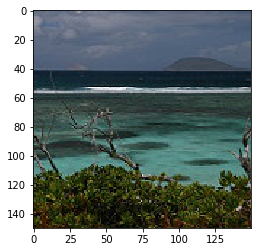

In [20]:
imshow(image_datasets['train'][8555][0]) # 5946

In [21]:
cuda_device = torch.device('cuda')
cpu_device = torch.device('cpu')
device = cuda_device

In [22]:
cd ../input/oniaa

/kaggle/input/oniaa


In [23]:
from convnet import IntelNet 
ptr = IntelNet().to(device)

In [24]:
cd ../../working

/kaggle/working


In [25]:
class BestModel:
    def __init__(self, path, initial_criterion):
        self.path = path
        self.criterion = initial_criterion
        
    def update(self, model, optimizer, criterion):
        self.criterion = criterion
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'criterion': criterion}, self.path)
        
    def load_model_data(self):
        return torch.load(self.path)
    
    def restore(self, model, optimizer):
        model_data = self.load_model_data()
        model.load_state_dict(model_data['model_state'])
        optimizer.load_state_dict(model_data['optimizer_state'])

In [26]:
def train_model(epochs, model, optimizer, criterion, loaders, device, best_model, n_prints=1):
    print_every = len(loaders['train']) // n_prints
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for iteration, (xx, yy) in enumerate(loaders['train']):
            optimizer.zero_grad()
            xx, yy = xx.to(device), yy.to(device)
            out = model(xx)
            loss = criterion(out, yy)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if(iteration % print_every == print_every - 1):
                running_train_loss /= print_every
                print(f"Epoch {epoch}, iteration {iteration} training_loss {running_train_loss}")
                running_train_loss = 0.0
            
        with torch.no_grad():
            model.eval()
            running_corrects = 0
            running_total = 0
            running_loss = 0.0
            for xx, yy in loaders['validation']:
                batch_size = xx.size(0)
                xx, yy = xx.to(device), yy.to(device)

                out = model(xx)
                
                loss = criterion(out, yy)
                running_loss += loss.item()
                
                predictions = out.argmax(1)
                running_corrects += (predictions == yy).sum().item()
                running_total += batch_size
            
            mean_val_loss = running_loss / len(loaders['validation'])
            accuracy = running_corrects / running_total
            
            if accuracy > best_model.criterion:
                best_model.update(model, optimizer, accuracy)
            
            print(f"Epoch {epoch}, val_loss {mean_val_loss}, accuracy = {accuracy}")
    best_model.restore(model, optimizer)
                
                
            
        

In [27]:
import time
start = time.time()

In [28]:
optimizer = torch.optim.Adam(ptr.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
best_model = BestModel('resnet_data',0.0)
train_model(5, ptr, optimizer, criterion,image_dataloaders, device, best_model=best_model, n_prints=5)

Epoch 0, iteration 157 training_loss 1.2924435998820052
Epoch 0, iteration 315 training_loss 0.8999697160494479
Epoch 0, iteration 473 training_loss 0.7771277391835104
Epoch 0, iteration 631 training_loss 0.7074114959451216
Epoch 0, iteration 789 training_loss 0.6245913352770142
Epoch 0, val_loss 0.5221437591720711, accuracy = 0.8126780626780626
Epoch 1, iteration 157 training_loss 0.5759014293928689
Epoch 1, iteration 315 training_loss 0.5796339315704152
Epoch 1, iteration 473 training_loss 0.613280130243754
Epoch 1, iteration 631 training_loss 0.5380814661142193
Epoch 1, iteration 789 training_loss 0.515452459831781
Epoch 1, val_loss 0.45816551775417547, accuracy = 0.8326210826210826
Epoch 2, iteration 157 training_loss 0.4738328014087828
Epoch 2, iteration 315 training_loss 0.4780730277865748
Epoch 2, iteration 473 training_loss 0.48060323373426367
Epoch 2, iteration 631 training_loss 0.4526384387495397
Epoch 2, iteration 789 training_loss 0.4509387919797173
Epoch 2, val_loss 0.3980

In [29]:
end = time.time()
print(end - start)

193.45034527778625


In [30]:
from torchvision.utils import make_grid

In [31]:
xx, yy = next(iter(image_dataloaders['validation']))

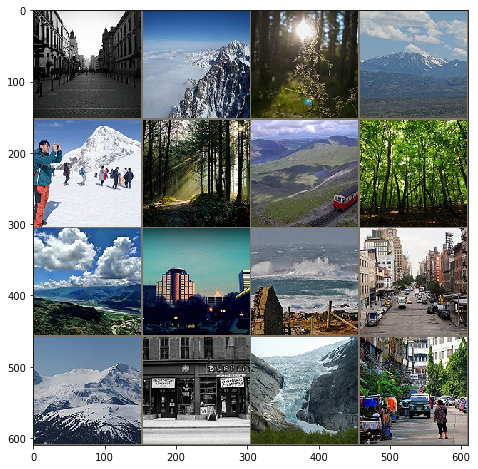

['street', 'mountain', 'forest', 'mountain', 'glacier', 'forest', 'mountain', 'forest', 'glacier', 'buildings', 'sea', 'street', 'glacier', 'street', 'glacier', 'street']
['street', 'mountain', 'forest', 'mountain', 'mountain', 'forest', 'mountain', 'forest', 'mountain', 'buildings', 'sea', 'street', 'mountain', 'street', 'glacier', 'street']


In [32]:
ptr.eval()
out = ptr(xx.cuda())
preds = out.argmax(1)
predicted_classes = [image_datasets['dev'].classes[c] for c in preds]
actual_classes = [image_datasets['dev'].classes[c] for c in yy]
imshow(make_grid(xx, nrow=4), fig_size=(8,8))
print(predicted_classes)
print(actual_classes)

In [33]:
all_preds = []
correct_preds = []
with torch.no_grad():
    ptr.eval()
    for xx, yy in image_dataloaders['test']:
        xx = xx.to(device)
        output = ptr(xx)
        all_preds.extend(output.argmax(1).tolist())
        correct_preds.extend(yy.tolist())

In [34]:
from sklearn import metrics

In [35]:
all_preds = np.asarray(all_preds)
correct_preds = np.asarray(correct_preds)

In [36]:
target_names = image_datasets['test'].classes
print(metrics.classification_report(correct_preds, all_preds,target_names=target_names))

              precision    recall  f1-score   support

   buildings       0.88      0.86      0.87       437
      forest       0.95      0.98      0.97       474
     glacier       0.87      0.82      0.84       553
    mountain       0.81      0.88      0.84       525
         sea       0.90      0.89      0.90       510
      street       0.90      0.89      0.90       501

   micro avg       0.89      0.89      0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.88      3000



In [37]:
confusion_matrix = metrics.confusion_matrix(correct_preds, all_preds)
pd.DataFrame(confusion_matrix, index=target_names, columns=target_names)

,buildings,forest,glacier,mountain,sea,street
buildings,378,6,5,4,6,38
forest,1,465,1,3,0,4
glacier,1,3,451,71,22,5
mountain,0,3,47,461,14,0
sea,13,6,10,27,454,0
street,38,6,2,3,6,446
